**Full Final Script - Done by Alma de Maria López, Izan Torrero and Lucia Navarro**

The following script have all the values and plots that give information about the evaluation of the relative contribution of interface residues to the interaction energy in a protein-protein complex. For further explanation read the final report that we conclude.

In [37]:
from Bio.PDB import *
import matplotlib.pyplot as plt
import biobb_structure_checking
from biobb_structure_checking import structure_checking
import os
import numpy as np
import math
import seaborn as sns
import matplotlib as mpl
from matplotlib.patches import Patch
from matplotlib.ticker import MaxNLocator
import warnings
import pandas as pd
import pickle

**Load the PDB structure**

In [38]:
parser=PDBParser(QUIET=True)
structure=parser.get_structure('6M0J','pdbfiles/6M0J.pdb')

Remove heteroatoms and clean the structure to retain only the protein chains for downstream structural analysis.

- *pdb_io.save*: Saves the cleaned sequence while preserving the original atom numbering

In [39]:
for model in structure:
    for chain in model:
        for resid in list(chain):
            if resid.id[0] != " ": # remove the HETATM
                chain.detach_child(resid.id)

pdb_io = PDBIO()
pdb_io.set_structure(structure)
pdb_io.save("pdbfiles/clean2.pdb" , write_end = True , preserve_atom_numbering = True)

In [40]:
p = os.path.dirname(biobb_structure_checking.__file__)
#print(p)

sclean=structure_checking.StructureChecking(p,args={
            'input_structure_path': 'pdbfiles/clean2.pdb',
            'output_structure_path': 'pdbfiles/clean2.pdbqt',
            'output_format' : 'pdbqt'
        })

Structure pdbfiles/clean2.pdb loaded
 PDB id:  
 Title: 
 Experimental method: unknown
 Resolution (A): N.A.

 Num. models: 1
 Num. chains: 2 (A: Protein, E: Protein)
 Num. residues:  791
 Num. residues with ins. codes:  0
 Num. residues with H atoms: 0
 Num. HETATM residues:  0
 Num. ligands or modified residues:  0
 Num. water mol.:  0
 Num. atoms:  6406


In [41]:
sclean.chains() # select the chains
sclean.altloc('occupancy') # select the conformation with the highest occupancy
sclean.altloc() # recheck
sclean.ligands() # look for ligands
sclean.amide('auto') # fix automatically unfavorable amide side-chain orientations
sclean.chiral() # chirality
# identify the missing backbone atoms or abnormalities an fix them
sclean.backbone()
sclean.backbone('--fix_atoms All --fix_chain none --add_caps none')
sclean.fixside() # check and fix the sidechains
sclean.getss('all') # -SS- bonds
# final checking
sclean.checkall()

Running chains.
Detected 2 Chain(s)
 A: Protein
 E: Protein
Running altloc. Options: occupancy
Detected 2 residues with alternative location labels
HIS A228
  CA   A (0.50) B (0.50)
  CB   A (0.50) B (0.50)
  CG   A (0.50) B (0.50)
  ND1  A (0.50) B (0.50)
  CD2  A (0.50) B (0.50)
  CE1  A (0.50) B (0.50)
  NE2  A (0.50) B (0.50)
GLN E493
  CA   A (0.50) B (0.50)
  CB   A (0.50) B (0.50)
  CG   A (0.50) B (0.50)
  CD   A (0.50) B (0.50)
  OE1  A (0.50) B (0.50)
  NE2  A (0.50) B (0.50)
Selecting location occupancy
Running altloc.
Detected no residues with alternative location labels
Running ligands.
No ligands found
Running amide. Options: auto
Found 7 unusual contact(s) involving amide atoms
 LYS A31.NZ   GLN E493.NE2    2.926 A
 GLN A42.NE2  GLN E498.NE2    2.927 A
 ASN A103.OD1 ASN A194.OD1    2.807 A
 ASN A134.OD1 GLU A140.OE2    2.785 A
 ASN A134.ND2 ASN A137.N      3.082 A
 GLU A150.O   ASN A154.OD1    2.895 A
 ARG E357.NH1 ASN E394.ND2    2.963 A
Fixing automatically
Initial con

In [42]:
opts = {'add_mode': 'auto','add_charges': 'CMIP'}

sclean.add_hydrogen(opts)
sclean.save_structure('pdbfiles/clean2.pdbqt')

Running add_hydrogen. Options: {'add_mode': 'auto', 'add_charges': 'CMIP'}
Found 226 Residues requiring selection on adding H atoms
Running fixside. Options: --fix all
Found no residues with missing or unknown side chain atoms
Selection: auto
Replacing HIS A34 by HIE
Replacing HIS A195 by HIE
Replacing HIS A228 by HIE
Replacing HIS A239 by HIE
Replacing HIS A241 by HIE
Replacing HIS A265 by HIE
Replacing HIS A345 by HIE
Replacing HIS A373 by HIE
Replacing HIS A374 by HIE
Replacing HIS A378 by HIE
Replacing HIS A401 by HIE
Replacing HIS A417 by HIE
Replacing HIS A493 by HIE
Replacing HIS A505 by HIE
Replacing HIS A535 by HIE
Replacing HIS A540 by HIE
Replacing HIS E519 by HIE
Updating partial charges and atom types
Total assigned charge:     -26.00


'pdbfiles/clean2.pdbqt'

The total assigned charge was -26.00 kcal/mol, in the following code it will store the charge values assigned to each atom for further analysis

In [43]:
params={}

with open('pdbfiles/clean2.pdbqt', 'r') as f:
    for line in f:
        if line.startswith(('ATOM', 'HETATM')) and len(line) >= 77:
            serial_num = int(line[6:11].strip())
            charge = float(line[69:76].strip())
            atom_type = line[77:].strip()
            params[serial_num] = {'charge': charge, 'type': atom_type}

st = parser.get_structure('6M0J', 'pdbfiles/clean2.pdbqt')
total_charge = 0.
for at in st.get_atoms():
    info = params.get(at.serial_number)
    if info:
        at.xtra["atom_type"] = info["type"]
        at.xtra["charge"] = info["charge"]
        total_charge += info["charge"]

print(f"Total charge: {total_charge:.2f}kcal/mol")

Total charge: -26.11kcal/mol


Get the interface based in distance

In [44]:
def get_interface_residues(structure, chain1_id, chain2_id, cutoff=8):
    # Identify interface residues between two chains.

    chain1 = structure[0][chain1_id]
    chain2 = structure[0][chain2_id]

    interface_chain1 = set()
    interface_chain2 = set()

    atoms_chain2 = [(res, atom.coord) for res in chain2 for atom in res] # coords

    for res1 in chain1:
        if res1.id[0] != " ":
            continue  # skip hetero residues for robustness
        for atom1 in res1:
            coord1 = atom1.coord
            for res2, coord2 in atoms_chain2:
                dist = np.linalg.norm(coord1 - coord2)
                if dist <= cutoff:
                    interface_chain1.add((res1.id[1], res1.resname))
                    interface_chain2.add((res2.id[1], res2.resname))
                    break # contact found
            else:
                continue
            break  # res-res contact found

    return sorted(interface_chain1), sorted(interface_chain2)


def expand_residues(res_list, chain, expand_by=1):
    expanded = set()
    residue_ids = {r[0] for r in res_list}  # set lookup is faster

    for res in chain:
        if res.id[0] != " ":
            continue  # skip hetero residues
        idx = res.id[1]
        # Check if within expand_by of any interface residue
        if any(abs(idx - r) <= expand_by for r in residue_ids):
            expanded.add((idx, res.resname))

    return sorted(expanded)


Getting the interface

In [45]:
structure = parser.get_structure("clean", "pdbfiles/clean2.pdbqt")

chain1_id = "A"
chain2_id = "E"
cutoff = 8

interface_A, interface_E = get_interface_residues(structure, chain1_id, chain2_id, cutoff)# Compute interface

# Expand interface
chainA = structure[0][chain1_id]
chainE = structure[0][chain2_id]

expanded_A = expand_residues(interface_A, chainA)
expanded_E = expand_residues(interface_E, chainE)

with open("interresidues/interfaceA.txt", "w") as f:
        f.write("Chain A interface residues:\n")
        for idx, name in expanded_A:
            f.write(f"{name} {idx}\n")
with open("interresidues/interfaceE.txt", "w") as f:
        f.write("\nChain E interface residues:\n")
        for idx, name in expanded_E:
            f.write(f"{name} {idx}\n")

**Getting interaction energies and plot the results**

Store needed parameters and usable interface

In [46]:
interactions={}
attypepar={}
fh = open('parameters/vdwprm.txt', "r")
for line in fh:
    if line[0] == '#':
        continue
    data = line.split()
    attypepar[data[0]]={'id':data[0],'eps':data[1],'sig':data[2],'mass':data[3],'fsrf':data[4]}

Store Interface atoms in a file that will be used on the following sections

In [47]:
def process_chain(interface_file, pdb_file, output_file, chain_key, attypepar):
    atomsofinter_chain = {}

    # Read interface residues
    with open(interface_file) as f:
        lines = f.readlines()[1:]  # skip header line
    reslocs = {line.strip().split()[1] for line in lines}  # use set for fast lookup

    # Read PDBQT once
    with open(pdb_file) as f:
        pdb_lines = f.readlines()[:-3]  # skip last 3 lines

    # Prepare output file
    with open(output_file, 'w') as out_f:
        for line in pdb_lines:
            tokens = line.strip().split()
            if tokens[0] == 'TER':
                continue
            if tokens[5] not in reslocs:
                continue

            # Write atom to output
            out_f.write(f"{line}")

            # Assign atom parameters
            atom_type_key = tokens[-1]
            if atom_type_key == 'O':
                interpar = attypepar['OH']
            elif atom_type_key == 'S':
                interpar = attypepar['SA']
            elif atom_type_key == 'HN':
                interpar = attypepar['N']
            else:
                interpar = attypepar[atom_type_key]

            atomsofinter_chain[tokens[1]] = {
                'aa': tokens[3],'type': tokens[-1],'charge': tokens[-2],
                'coord': tokens[6:9],'resloc': tokens[5],'restype': tokens[4],
                'sig': interpar['sig'],'eps': interpar['eps'],'fsrf': interpar['fsrf'],'mass': interpar['mass']
                }

    return atomsofinter_chain

atomsofinter = {
    'A': process_chain('interresidues/interfaceA.txt', 'pdbfiles/clean2.pdbqt', 'pdbfiles/chainAinterface.pdbqt', 'A', attypepar),
    'E': process_chain('interresidues/interfaceE.txt', 'pdbfiles/clean2.pdbqt', 'pdbfiles/chainEinterface.pdbqt', 'E', attypepar)
}



**Electrostatic Interaction Energy**

In [48]:
def dielectricfun(r):
    A = 86.9525
    B = 7.7839
    k = 0.3153
    C = 8.5525

    epsilon_r = A / (1 + B * np.exp(-k * r)) - C
    return epsilon_r

def electrointeraction(r, charge1, charge2):
    if r > 8.0:
        return 0.0
    k = 332.0636
    dielectric = dielectricfun(r)

    return (k * charge1 * charge2) / (dielectric *r)

**Vdw interaction energy**

In [49]:
def vdw_int(r,sig1,sig2,eps1,eps2):
    eps12 = math.sqrt(abs(eps1 * eps2))
    sig12_2 = (sig1 + sig2)/2

    return 4 * eps12 * (sig12_2**6/r**12 - sig12_2**3/r**6)

**Pairwise interaction energy**

In [50]:
def paiwiseenergy(atomsofinter):
    interactions={}
    E_elec = 0.0
    E_vdw = 0.0
    i=0
    for a in atomsofinter['A']:
        a=atomsofinter['A'][a]
        coord_a = np.array([float(x) for x in a['coord']])
        q_a = float(a['charge'])
        sig1 = float(a['sig'])
        eps1 = float(a['eps'])
        for e in atomsofinter['E']:
            e=atomsofinter['E'][e]
            coord_e = np.array([float(x) for x in e['coord']])
            q_e = float(e['charge'])
            sig2 = float(e['sig'])
            eps2 = float(e['eps'])
            r = np.linalg.norm(np.array(coord_a) - np.array(coord_e))
            if r<8.0:
                elec=electrointeraction(r, q_a, q_e)
                vdw=vdw_int(r,sig1,sig2,eps1,eps2)
                E_elec += elec
                E_vdw += vdw

                interactions[(a['aa'],a['resloc'],e['aa'],e['resloc'])]={'elec':elec , 'vdw':vdw}
    return E_elec,E_vdw,interactions

E_elec,E_vdw,interactions=paiwiseenergy(atomsofinter)
print(f"Electrostatic Interaction energy: {round(E_elec, 3)}kcal/mol")
print(f"Van der Waals Energy: {round(E_vdw,3)}kcal/mol")


Electrostatic Interaction energy: -16.868kcal/mol
Van der Waals Energy: -8.902kcal/mol


Plot of interaction energies

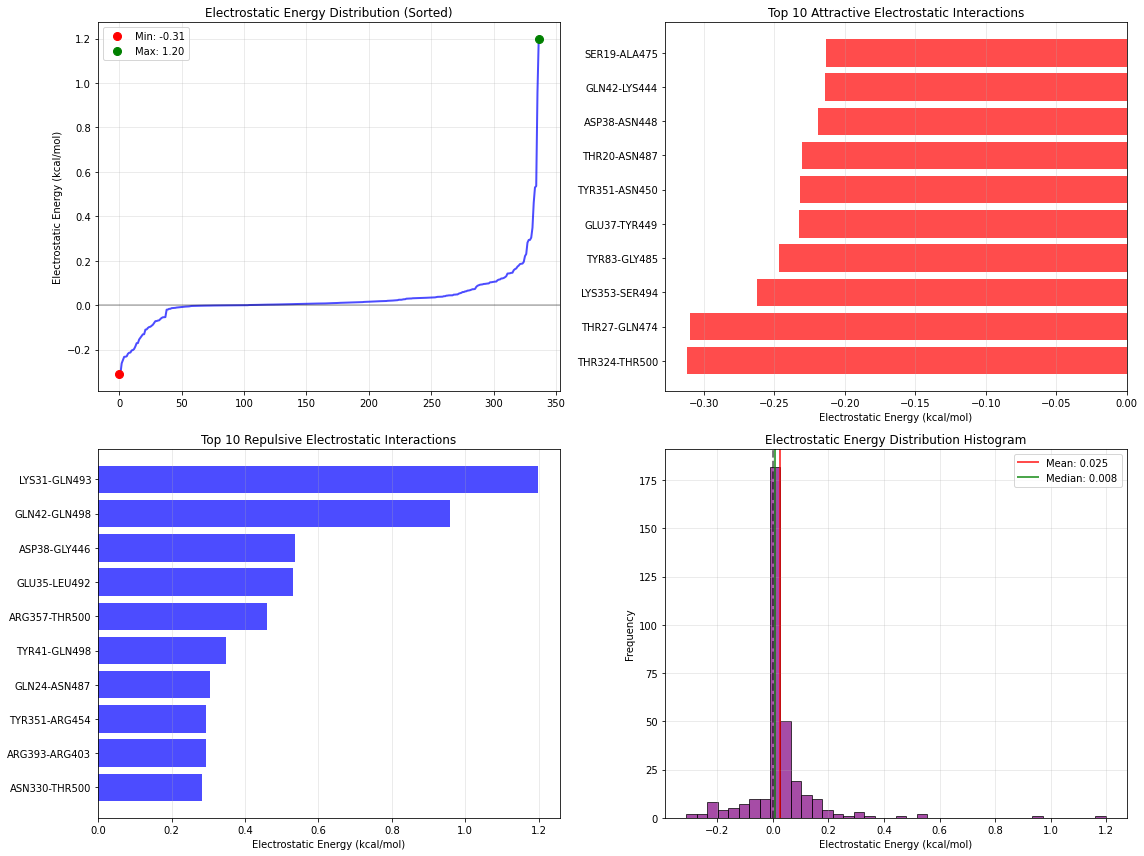

In [51]:

def plot_electrostatic_energy_distribution(interactions, top_n=10):
    melec = sorted(interactions.items(), key=lambda x: x[1]['elec']) # electrostatic energy
    # Extract data for plotting
    xelec = []
    yelec = []
    interaction_labels = []

    for key, value in melec:
        # Create label for x-axis: ACE2-RBD residue pair
        label = f"{key[0]}{key[1]}-{key[2]}{key[3]}"
        interaction_labels.append(label)
        yelec.append(value['elec'])
        xelec.append(label)

    # Create figure with multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Plot 1: Line plot of electrostatic energies
    axes[0, 0].plot(range(len(yelec)), yelec, 'b-', linewidth=2, alpha=0.7)
    axes[0, 0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    axes[0, 0].set_ylabel('Electrostatic Energy (kcal/mol)')
    axes[0, 0].set_title('Electrostatic Energy Distribution (Sorted)')
    axes[0, 0].grid(True, alpha=0.3)

    # Add labels for extreme values
    min_idx = np.argmin(yelec)
    max_idx = np.argmax(yelec)
    axes[0, 0].plot(min_idx, yelec[min_idx], 'ro', markersize=8, label=f'Min: {yelec[min_idx]:.2f}')
    axes[0, 0].plot(max_idx, yelec[max_idx], 'go', markersize=8, label=f'Max: {yelec[max_idx]:.2f}')
    axes[0, 0].legend()

    # Plot 2: Bar plot of top N attractive electrostatic interactions
    top_attractive = melec[:top_n]  # Most negative (attractive)
    top_labels = [f"{k[0]}{k[1]}-{k[2]}{k[3]}" for k, v in top_attractive]
    top_energies = [v['elec'] for k, v in top_attractive]

    axes[0, 1].barh(range(len(top_attractive)), top_energies, color='red', alpha=0.7)
    axes[0, 1].set_yticks(range(len(top_attractive)))
    axes[0, 1].set_yticklabels(top_labels)
    axes[0, 1].set_xlabel('Electrostatic Energy (kcal/mol)')
    axes[0, 1].set_title(f'Top {top_n} Attractive Electrostatic Interactions')
    axes[0, 1].grid(True, alpha=0.3, axis='x')


    # Plot 3: Bar plot of top N repulsive electrostatic interactions
    top_repulsive = melec[-top_n:]  # Most positive (repulsive)

    rep_labels = [f"{k[0]}{k[1]}-{k[2]}{k[3]}" for k, v in top_repulsive]
    rep_energies = [v['elec'] for k, v in top_repulsive]

    axes[1, 0].barh(range(len(top_repulsive)), rep_energies, color='blue', alpha=0.7)
    axes[1, 0].set_yticks(range(len(top_repulsive)))
    axes[1, 0].set_yticklabels(rep_labels)
    axes[1, 0].set_xlabel('Electrostatic Energy (kcal/mol)')
    axes[1, 0].set_title(f'Top {top_n} Repulsive Electrostatic Interactions')
    axes[1, 0].grid(True, alpha=0.3, axis='x')

    # Plot 4: Histogram of electrostatic energy distribution
    all_elec_energies = [v['elec'] for v in interactions.values()]
    axes[1, 1].hist(all_elec_energies, bins=40, alpha=0.7, color='purple', edgecolor='black')
    axes[1, 1].axvline(x=0, color='black', linestyle='--', linewidth=2, alpha=0.5)
    axes[1, 1].axvline(x=np.mean(all_elec_energies), color='red', linestyle='-',
                      linewidth=2, alpha=0.7, label=f'Mean: {np.mean(all_elec_energies):.3f}')
    axes[1, 1].axvline(x=np.median(all_elec_energies), color='green', linestyle='-',
                      linewidth=2, alpha=0.7, label=f'Median: {np.median(all_elec_energies):.3f}')
    axes[1, 1].set_xlabel('Electrostatic Energy (kcal/mol)')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Electrostatic Energy Distribution Histogram')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('plots/electrostatic_energy_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()


plot_electrostatic_energy_distribution(interactions,10)

**Plot van der walls**

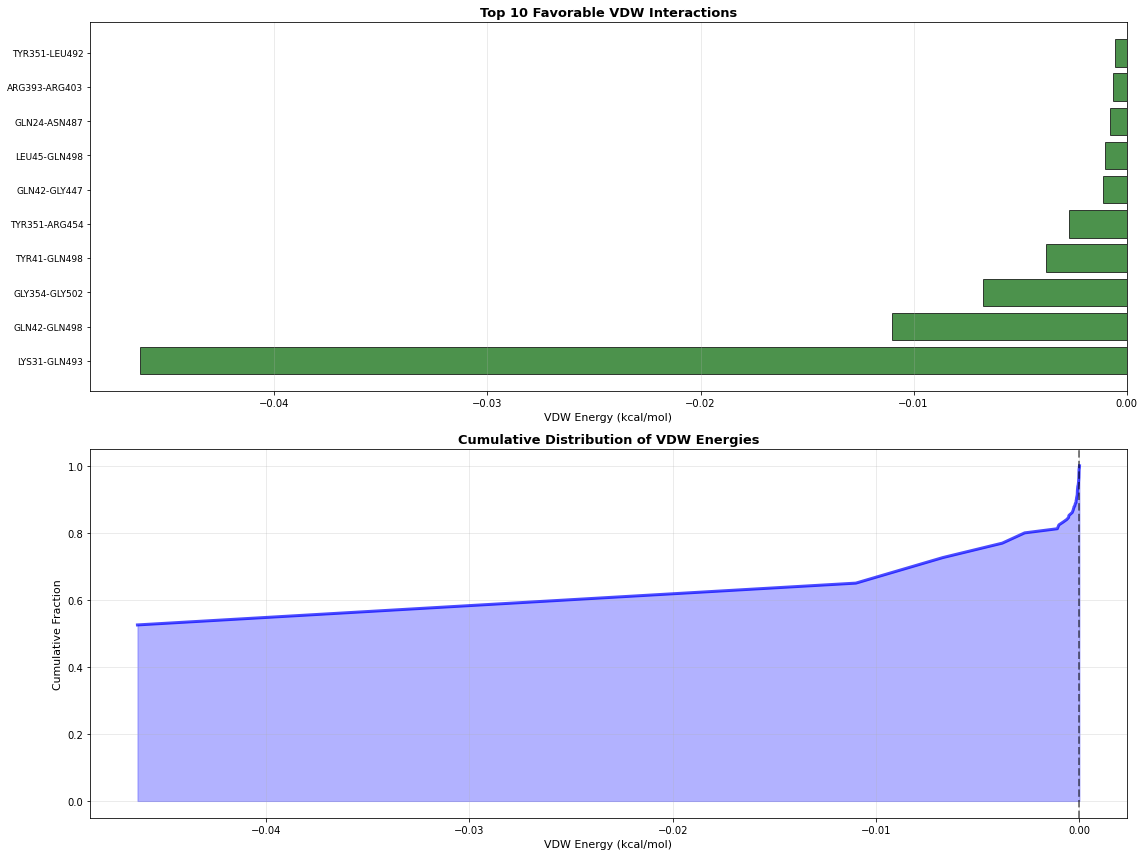

In [52]:
def plot_vdw_energy_distribution(interactions, top_n=30):
    mvdw = sorted(interactions.items(), key=lambda x: x[1]['vdw']) # vdw energies
    fig, axes = plt.subplots(2, figsize=(16, 12))

    # Plot 1: Line plot of VDW energies (top-left)
    vdw_energies = [v['vdw'] for k, v in mvdw]

    # Plot 2: Bar plot of top N favorable VDW interactions (top-right)
    top_favorable = mvdw[:top_n]  # Most negative (favorable)
    top_labels = [f"{k[0]}{k[1]}-{k[2]}{k[3]}" for k, v in top_favorable]
    top_vdw = [v['vdw'] for k, v in top_favorable]

    # Calculate bar positions
    y_pos = np.arange(len(top_favorable))

    axes[0].barh(y_pos, top_vdw, color='darkgreen', alpha=0.7, edgecolor='black')
    axes[0].set_yticks(y_pos)
    axes[0].set_yticklabels(top_labels, fontsize=9)
    axes[0].set_xlabel('VDW Energy (kcal/mol)', fontsize=11)
    axes[0].set_title(f'Top {top_n} Favorable VDW Interactions', fontsize=13, fontweight='bold')

    axes[0].grid(True, alpha=0.3, axis='x')

    # Plot 2: Cumulative distribution of VDW energies (bottom-right)
    sorted_vdw = np.sort(vdw_energies)
    cumulative = np.cumsum(sorted_vdw)
    cumulative_normalized = cumulative / cumulative[-1] if cumulative[-1] != 0 else cumulative

    axes[1].plot(sorted_vdw, cumulative_normalized, 'b-', linewidth=3, alpha=0.7)
    axes[1].fill_between(sorted_vdw, cumulative_normalized, 0, alpha=0.3, color='blue')
    axes[1].axvline(x=0, color='black', linestyle='--', linewidth=2, alpha=0.5)
    axes[1].set_xlabel('VDW Energy (kcal/mol)', fontsize=11)
    axes[1].set_ylabel('Cumulative Fraction', fontsize=11)
    axes[1].set_title('Cumulative Distribution of VDW Energies', fontsize=13, fontweight='bold')
    axes[1].grid(True, alpha=0.3)

    # Adjust layout and save
    plt.tight_layout()
    plt.savefig('plots/vdw_energy_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_vdw_energy_distribution(interactions, top_n=10)



/tmp/ipykernel_1364/3267477878.py:113: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 0].boxplot(box_data, labels=df['Type'].unique())


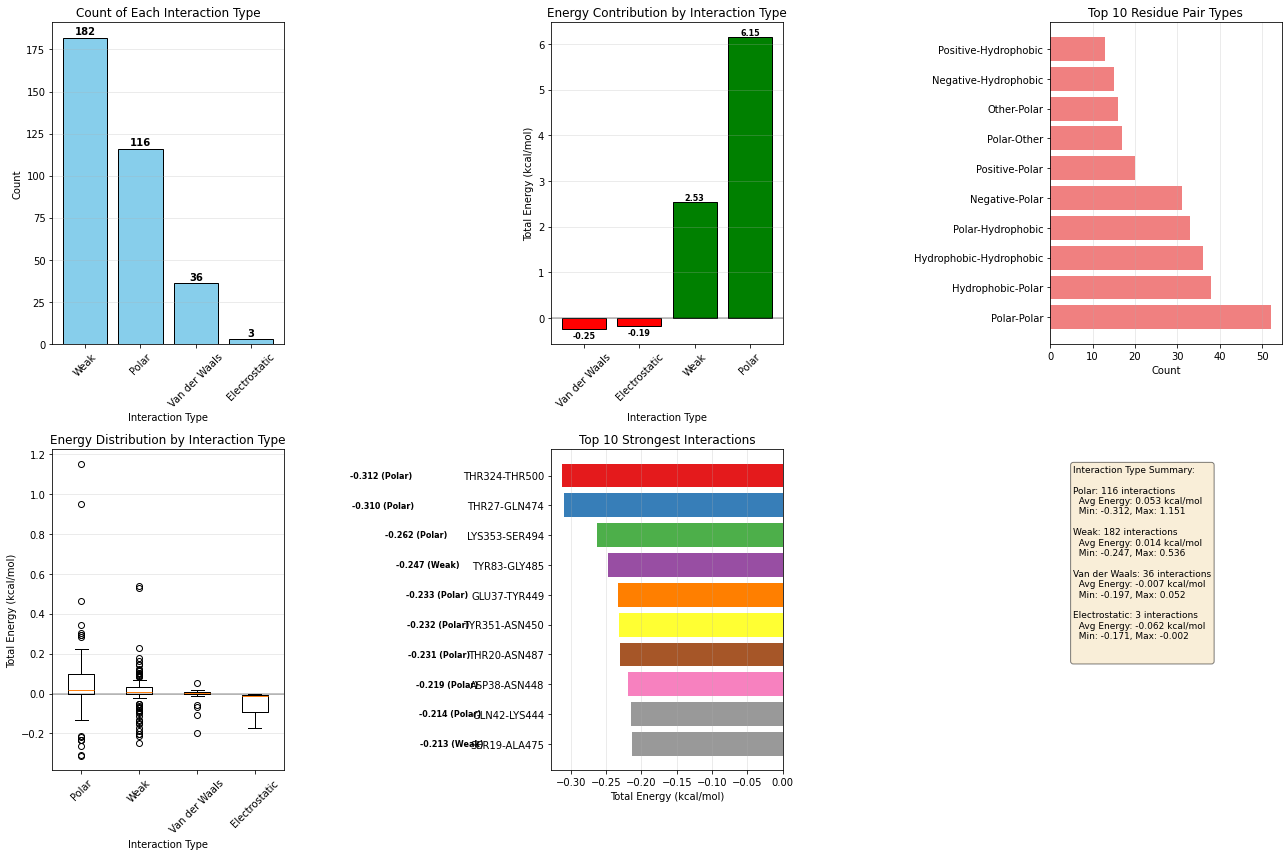

,ACE2,RBD,ACE2_Type,RBD_Type,Electrostatic,VDW,Total,Type,Pair_Type
0,SER19,TYR473,Polar,Polar,0.071927,-0.000038,0.071889,Polar,Polar-Polar
1,SER19,GLN474,Polar,Polar,0.044379,-0.000046,0.044333,Polar,Polar-Polar
2,SER19,ALA475,Polar,Hydrophobic,-0.213270,-0.000000,-0.213270,Weak,Polar-Hydrophobic
3,SER19,GLY476,Polar,Other,0.035010,-0.000000,0.035010,Weak,Polar-Other
4,SER19,SER477,Polar,Polar,0.020302,-0.000000,0.020302,Polar,Polar-Polar
...,...,...,...,...,...,...,...,...,...
332,TRP353,LEU452,Hydrophobic,Hydrophobic,-0.057449,-0.000024,-0.057474,Van der Waals,Hydrophobic-Hydr...
333,TRP353,TYR453,Hydrophobic,Polar,0.016860,-0.000008,0.016853,Weak,Hydrophobic-Polar
334,TRP353,ILE402,Hydrophobic,Hydrophobic,0.001454,-0.000006,0.001448,Van der Waals,Hydrophobic-Hydr...
335,TRP353,ILE418,Hydrophobic,Hydrophobic,-0.196937,-0.000104,-0.197041,Van der Waals,Hydrophobic-Hydr...


In [53]:
def classify_and_plot_interactions(interactions):

    def classify_residue(resname):
        hydrophobic = {'ALA', 'VAL', 'LEU', 'ILE', 'MET', 'PHE', 'TRP', 'PRO'}
        positive = {'ARG', 'LYS', 'HIS'}
        negative = {'ASP', 'GLU'}
        polar = {'SER', 'THR', 'ASN', 'GLN', 'TYR', 'CYS'}

        if resname in hydrophobic:
            return 'Hydrophobic'
        elif resname in positive:
            return 'Positive'
        elif resname in negative:
            return 'Negative'
        elif resname in polar:
            return 'Polar'
        else:
            return 'Other'

    # Classify each interaction
    interaction_data = []
    for key, values in interactions.items():
        res1_name = key[0]  # ACE2 residue
        res1_num = key[1]
        res2_name = key[2]  # RBD residue
        res2_num = key[3]

        elec = values['elec']
        vdw = values['vdw']
        total = elec + vdw

        res1_type = classify_residue(res1_name)
        res2_type = classify_residue(res2_name)

        if res1_type == 'Positive' and res2_type == 'Negative' or res1_type == 'Negative' and res2_type == 'Positive':
            if elec < -2.0:
                interaction_type = 'Salt Bridge'
            else:
                interaction_type = 'Electrostatic'
        elif res1_type == 'Hydrophobic' and res2_type == 'Hydrophobic':
            if vdw < -0.5:
                interaction_type = 'Hydrophobic'
            else:
                interaction_type = 'Van der Waals'
        elif (res1_type in ['Positive', 'Polar', 'Negative'] and
              res2_type in ['Positive', 'Polar', 'Negative']):
            if elec < -1.0:
                interaction_type = 'Hydrogen Bond'
            else:
                interaction_type = 'Polar'
        else:
            if abs(total) > 1.0:
                interaction_type = 'Mixed'
            else:
                interaction_type = 'Weak'

        interaction_data.append({
            'ACE2': f"{res1_name}{res1_num}",
            'RBD': f"{res2_name}{res2_num}",
            'ACE2_Type': res1_type,
            'RBD_Type': res2_type,
            'Electrostatic': elec,
            'VDW': vdw,
            'Total': total,
            'Type': interaction_type,
            'Pair_Type': f"{res1_type}-{res2_type}"
        })

    df = pd.DataFrame(interaction_data)

    # Create the classification plots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Plot 1: Count of each interaction type
    type_counts = df['Type'].value_counts()
    axes[0, 0].bar(type_counts.index, type_counts.values, color='skyblue', edgecolor='black')
    axes[0, 0].set_xlabel('Interaction Type')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].set_title('Count of Each Interaction Type')
    axes[0, 0].tick_params(axis='x', rotation=45)
    axes[0, 0].grid(True, alpha=0.3, axis='y')

    for i, v in enumerate(type_counts.values):
        axes[0, 0].text(i, v + max(type_counts.values)*0.01, str(v),
                       ha='center', fontweight='bold')

    # Plot 2: Energy contribution by interaction type
    type_energy = df.groupby('Type')['Total'].sum().sort_values()
    colors = ['red' if x < 0 else 'green' for x in type_energy.values]
    axes[0, 1].bar(type_energy.index, type_energy.values, color=colors, edgecolor='black')
    axes[0, 1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    axes[0, 1].set_xlabel('Interaction Type')
    axes[0, 1].set_ylabel('Total Energy (kcal/mol)')
    axes[0, 1].set_title('Energy Contribution by Interaction Type')
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].grid(True, alpha=0.3, axis='y')

    for i, v in enumerate(type_energy.values):
        axes[0, 1].text(i, v + (0.05 if v >= 0 else -0.2), f'{v:.2f}',
                       ha='center', fontweight='bold', fontsize=8)

    # Plot 3: Pair type frequency
    pair_counts = df['Pair_Type'].value_counts().head(10)
    axes[0, 2].barh(range(len(pair_counts)), pair_counts.values, color='lightcoral')
    axes[0, 2].set_yticks(range(len(pair_counts)))
    axes[0, 2].set_yticklabels(pair_counts.index)
    axes[0, 2].set_xlabel('Count')
    axes[0, 2].set_title('Top 10 Residue Pair Types')
    axes[0, 2].grid(True, alpha=0.3, axis='x')

    # Plot 4: Energy distribution by interaction type (box plot)
    box_data = [df[df['Type'] == t]['Total'].values for t in df['Type'].unique()]
    axes[1, 0].boxplot(box_data, labels=df['Type'].unique())
    axes[1, 0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    axes[1, 0].set_xlabel('Interaction Type')
    axes[1, 0].set_ylabel('Total Energy (kcal/mol)')
    axes[1, 0].set_title('Energy Distribution by Interaction Type')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].grid(True, alpha=0.3, axis='y')

    # Plot 5: Top 10 strongest interactions by type
    top_interactions = df.nsmallest(10, 'Total')
    y_pos = np.arange(len(top_interactions))
    axes[1, 1].barh(y_pos, top_interactions['Total'],
                   color=[plt.cm.Set1(i) for i in range(len(top_interactions))])
    axes[1, 1].set_yticks(y_pos)
    axes[1, 1].set_yticklabels([f"{row['ACE2']}-{row['RBD']}" for _, row in top_interactions.iterrows()])
    axes[1, 1].set_xlabel('Total Energy (kcal/mol)')
    axes[1, 1].set_title('Top 10 Strongest Interactions')
    axes[1, 1].invert_yaxis()
    axes[1, 1].grid(True, alpha=0.3, axis='x')

    for i, v in enumerate(top_interactions['Total']):
        axes[1, 1].text(v + (0.05 if v >= 0 else -0.3), i,
                       f'{v:.3f} ({top_interactions.iloc[i]["Type"]})',
                       va='center', fontweight='bold', fontsize=8)

    # Plot 6: Interaction type vs distance (if distance data available)
    if 'distance' in next(iter(interactions.values())):
        distances = [v.get('distance', 0) for v in interactions.values()]
        axes[1, 2].scatter(distances, df['Total'], c=df['Total'],
                          cmap='RdYlBu', alpha=0.7, s=50, edgecolor='black')
        axes[1, 2].axhline(y=0, color='black', linestyle='-', alpha=0.3)
        axes[1, 2].set_xlabel('Distance (Å)')
        axes[1, 2].set_ylabel('Total Energy (kcal/mol)')
        axes[1, 2].set_title('Energy vs Distance (colored by energy)')
        axes[1, 2].grid(True, alpha=0.3)
    else:
        # If no distance data, show a summary table
        axes[1, 2].axis('off')
        summary_text = "Interaction Type Summary:\n\n"
        for inter_type in df['Type'].unique():
            subset = df[df['Type'] == inter_type]
            count = len(subset)
            avg_energy = subset['Total'].mean()
            summary_text += f"{inter_type}: {count} interactions\n"
            summary_text += f"  Avg Energy: {avg_energy:.3f} kcal/mol\n"
            summary_text += f"  Min: {subset['Total'].min():.3f}, Max: {subset['Total'].max():.3f}\n\n"

        axes[1, 2].text(0.1, 0.95, summary_text, transform=axes[1, 2].transAxes,
                       fontsize=9, verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    plt.savefig('plots/interaction_classification.png', dpi=300, bbox_inches='tight')
    plt.show()

    return df

classify_and_plot_interactions(interactions)

In [54]:

def generate_interaction_table(interactions, top_n=20):
    # Calculate total energy
    for key in interactions:
        interactions[key]['total'] = interactions[key]['elec'] + interactions[key]['vdw']

    # Sort by absolute total energy
    sorted_interactions = sorted(interactions.items(),
                                 key=lambda x: abs(x[1]['total']),
                                 reverse=True)

    # Create table data
    table_data = []
    for i, (key, values) in enumerate(sorted_interactions[:top_n]):
        res1_name, res1_num, res2_name, res2_num = key

        # Determine if interaction is favorable (negative energy)
        is_favorable = values['total'] < 0

        # Classify interaction type based on energies
        if values['elec'] < -2.0 and abs(values['elec']) > abs(values['vdw']):
            interaction_type = "Strong Electrostatic"
        elif values['elec'] < -1.0:
            interaction_type = "Electrostatic"
        elif values['vdw'] < -1.0:
            interaction_type = "Strong VDW"
        elif values['vdw'] < -0.5:
            interaction_type = "VDW"
        elif abs(values['elec']) > 1.0 and abs(values['vdw']) > 1.0:
            interaction_type = "Mixed Strong"
        else:
            interaction_type = "Mixed Weak"

        table_data.append({
            'Rank': i + 1,
            'ACE2_Residue': f"{res1_name}{res1_num}",
            'RBD_Residue': f"{res2_name}{res2_num}",
            'Electrostatic_Energy': f"{values['elec']:.3f}",
            'VDW_Energy': f"{values['vdw']:.3f}",
            'Total_Energy': f"{values['total']:.3f}",
            'Favorable': 'Yes' if is_favorable else 'No',
            'Interaction_Type': interaction_type,
            'Strength': 'Strong' if abs(values['total']) > 2.0 else 'Moderate' if abs(values['total']) > 1.0 else 'Weak'
        })

    # Convert to DataFrame
    df_table = pd.DataFrame(table_data)

    # Print the table
    print(f"\nTop {top_n} interactions sorted by interaction strength:\n")

    # Format the table for display
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 120)
    pd.set_option('display.max_colwidth', 20)

    print(df_table.to_string(index=False))

    print("SUMMARY:")

    print(f"Total number of interactions analyzed: {len(interactions)}")
    print(f"Number of favorable interactions (negative energy): {sum(1 for v in interactions.values() if v['total'] < 0)}")
    print(f"Number of unfavorable interactions (positive energy): {sum(1 for v in interactions.values() if v['total'] > 0)}")

    # Calculate average energies
    avg_elec = np.mean([v['elec'] for v in interactions.values()])
    avg_vdw = np.mean([v['vdw'] for v in interactions.values()])
    avg_total = np.mean([v['total'] for v in interactions.values()])

    print(f"\nAverage Electrostatic Energy: {avg_elec:.3f} kcal/mol")
    print(f"Average VDW Energy: {avg_vdw:.3f} kcal/mol")
    print(f"Average Total Interaction Energy: {avg_total:.3f} kcal/mol")

    # Find strongest interactions
    strongest_elec = min(interactions.items(), key=lambda x: x[1]['elec'])
    strongest_vdw = min(interactions.items(), key=lambda x: x[1]['vdw'])
    strongest_total = min(interactions.items(), key=lambda x: x[1]['total'])

    print(f"\nSTRONGEST INTERACTIONS:")
    print(f"- Strongest Electrostatic: {strongest_elec[0][0]}{strongest_elec[0][1]}-{strongest_elec[0][2]}{strongest_elec[0][3]} "
          f"({strongest_elec[1]['elec']:.3f} kcal/mol)")
    print(f"- Strongest VDW: {strongest_vdw[0][0]}{strongest_vdw[0][1]}-{strongest_vdw[0][2]}{strongest_vdw[0][3]} "
          f"({strongest_vdw[1]['vdw']:.3f} kcal/mol)")
    print(f"- Strongest Overall: {strongest_total[0][0]}{strongest_total[0][1]}-{strongest_total[0][2]}{strongest_total[0][3]} "
          f"({strongest_total[1]['total']:.3f} kcal/mol)")

    # Save to CSV
    df_table.to_csv('plots/most_relevant_interactions.csv', index=False)
    print(f"\nDetailed table saved to 'most_relevant_interactions.csv'")

    return df_table
generate_interaction_table(interactions,10)


Top 10 interactions sorted by interaction strength:

 Rank ACE2_Residue RBD_Residue Electrostatic_Energy VDW_Energy Total_Energy Favorable Interaction_Type Strength
    1        LYS31      GLN493                1.198     -0.046        1.151        No       Mixed Weak Moderate
    2        GLN42      GLN498                0.958     -0.011        0.947        No       Mixed Weak     Weak
    3        ASP38      GLY446                0.536     -0.000        0.536        No       Mixed Weak     Weak
    4        GLU35      LEU492                0.530     -0.000        0.530        No       Mixed Weak     Weak
    5       ARG357      THR500                0.461     -0.000        0.461        No       Mixed Weak     Weak
    6        TYR41      GLN498                0.349     -0.004        0.345        No       Mixed Weak     Weak
    7       THR324      THR500               -0.312     -0.000       -0.312       Yes       Mixed Weak     Weak
    8        THR27      GLN474               -0.31

,Rank,ACE2_Residue,RBD_Residue,Electrostatic_Energy,VDW_Energy,Total_Energy,Favorable,Interaction_Type,Strength
0,1,LYS31,GLN493,1.198,-0.046,1.151,No,Mixed Weak,Moderate
1,2,GLN42,GLN498,0.958,-0.011,0.947,No,Mixed Weak,Weak
2,3,ASP38,GLY446,0.536,-0.000,0.536,No,Mixed Weak,Weak
3,4,GLU35,LEU492,0.530,-0.000,0.530,No,Mixed Weak,Weak
4,5,ARG357,THR500,0.461,-0.000,0.461,No,Mixed Weak,Weak
5,6,TYR41,GLN498,0.349,-0.004,0.345,No,Mixed Weak,Weak
6,7,THR324,THR500,-0.312,-0.000,-0.312,Yes,Mixed Weak,Weak
7,8,THR27,GLN474,-0.310,-0.000,-0.310,Yes,Mixed Weak,Weak
8,9,GLN24,ASN487,0.304,-0.001,0.303,No,Mixed Weak,Weak
9,10,ARG393,ARG403,0.294,-0.001,0.293,No,Mixed Weak,Weak


**Energy solvation**

In [55]:
def parse_asa_file(asa_file_path):
    atom_asa = {}
    with open(asa_file_path, 'r') as f:
        for line in f:
            if line.startswith('ATOM'):
                # parameters
                atom_num = int(line[6:11].strip())
                atom_name = line[12:16].strip()
                res_name = line[17:20].strip()
                chain = line[21].strip()
                res_num = int(line[22:26].strip())

                # Parse ASA
                asa = float(line[62:68].strip())
                atom_asa[str(atom_num)] = {'asa':asa , 'type':atom_name}
    return atom_asa

asacomplex=parse_asa_file('naccessoutputs/clean2.asa')
asachaina=parse_asa_file('naccessoutputs/6M0J_A.asa')
asachaine=parse_asa_file('naccessoutputs/6M0J_E.asa')

In [56]:
def computesolvenerg(asa,atomsofinter,alascan=False):
    solve=0
    for a in asa:
        if a in atomsofinter['A'] or a in atomsofinter['E']:
            if asa[a]['type']=='O':
                fsrf = attypepar['OA']['fsrf']
            elif asa[a]['type']=='CA':
                fsrf = attypepar['C']['fsrf']
            elif asa[a]['type']=='CB':
                fsrf = attypepar['C']['fsrf']
            elif asa[a]['type'][:2]=='OG' :
                fsrf = attypepar['OH']['fsrf']
            elif asa[a]['type'][:2] in ('CG1','CG', 'CD', 'CD2', 'CE', 'CE2', 'CZ','CG2', 'CD1', 'CD2', 'CE1', 'CE2','CE3', 'CZ', 'CH2'):
                fsrf = attypepar['A']['fsrf']
            elif asa[a]['type'][:2]=='HG' :
                fsrf = attypepar['H']['fsrf']
            elif asa[a]['type'] in ('OD1', 'OD2', 'OE1', 'OE2') :
                fsrf = attypepar['OC']['fsrf']
            elif asa[a]['type'][0] == 'N' :
                fsrf = attypepar['N']['fsrf']
            elif asa[a]['type'][:2] in ('HZ1', 'HZ2', 'HZ3', 'HE', 'HD') :
                fsrf = attypepar['N']['fsrf']
            elif asa[a]['type'][:2] not in ('CG1','CG', 'CD', 'CD2', 'CE', 'CE2', 'CZ','CG2', 'CD1', 'CD2', 'CE1', 'CE2','CE3', 'CZ', 'CH2'):
                fsrf = attypepar['C']['fsrf']
            else:

                fsrf = attypepar[asa[a]['type']]['fsrf']
            asaval=asa[str(a)]['asa']

            solve+= float(fsrf) * float(asaval)


    return solve

solvcomp=computesolvenerg(asachaina,atomsofinter)
solva=computesolvenerg(asachaine,atomsofinter)
solve=computesolvenerg(asacomplex,atomsofinter)

In [57]:
solvenergy=solvcomp - solva - solve
totalenergy=E_elec + E_vdw + (solvcomp - solva - solve)
print(f"The solvation energies are {round(solvcomp, 3)}kcal/mol (AE), {round(solva,3)}kcal/mol (A), {round(solve, 3)}kcal/mol (E)")

print(f"The total Energy: {round(totalenergy,4)}kcal/mol")

The solvation energies are 27.928kcal/mol (AE), 8.424kcal/mol (A), 33.193kcal/mol (E)
The total Energy: -39.4589kcal/mol


**ALA SCANNING**

In [58]:
def build_atomsofinter_lookup(atomsofinter):
    """ Build a lookup table from atomsofinter dictionary """
    lookup = {}
    for chain_id, atoms in atomsofinter.items():
        for _, data in atoms.items():
            key = (chain_id, int(data["resloc"]), data["type"])
            lookup[key] = {
                "charge": float(data["charge"]),
                "sigma": float(data["sig"]),
                "epsilon": float(data["eps"]),
                "coord": np.array(data["coord"], dtype=float),
            }
    return lookup

# select the ala values
ALA_BACKBONE_NAMES = {"N", "CA", "C", "O", "CB"}

def is_ala_like_atom(atom):
    """Return True if this atom is part of Ala-like residue (backbone + CB)."""
    return atom.get_name().strip() in ALA_BACKBONE_NAMES

def compute_total_DG(structure, chainA_id, chainE_id,interface_A, interface_E, atom_lookup,mutate_res=None, cutoff=10.0):
    """
    Compute ΔG_total = E_elec + E_vdw for chains A and E.
    mutate_res: tuple (chain_id, res_seq) or None.
    Only non-Ala side-chain atoms of mutate_res are ignored.
    """

    model = structure[0]
    chainA = model[chainA_id]
    chainE = model[chainE_id]

    # Build sets of interface residues: (resid, resname)
    interface_A_lookup = {(resid, resname) for resid, resname in interface_A}
    interface_E_lookup = {(resid, resname) for resid, resname in interface_E}

    E_elec = 0.0
    E_vdw  = 0.0

    for resA in chainA:
        keyA = (resA.id[1], resA.resname)
        if keyA not in interface_A_lookup:
            continue

        for resE in chainE:
            keyE = (resE.id[1], resE.resname)
            if keyE not in interface_E_lookup:
                continue

            for atomA in resA:
                # Skip non-Ala side-chain atoms if this residue is mutated
                if mutate_res is not None:
                    mut_chain, mut_resid = mutate_res
                    if (mut_chain == chainA_id and resA.id[1] == mut_resid
                        and not is_ala_like_atom(atomA)):
                        continue

                key_atomA = (chainA_id, resA.id[1], atomA.get_name().strip())
                if key_atomA not in atom_lookup:
                    continue
                pA = atom_lookup[key_atomA]
                qA, sigA, epsA = pA["charge"], pA["sigma"], pA["epsilon"]
                coordA = pA["coord"]
                for atomE in resE:
                    if mutate_res is not None:
                        mut_chain, mut_resid = mutate_res
                        if (mut_chain == chainE_id and resE.id[1] == mut_resid
                            and not is_ala_like_atom(atomE)):
                            continue

                    key_atomE = (chainE_id, resE.id[1], atomE.get_name().strip())
                    if key_atomE not in atom_lookup:
                        continue
                    pE = atom_lookup[key_atomE]
                    qE, sigE, epsE = pE["charge"], pE["sigma"], pE["epsilon"]
                    coordE = pE["coord"]

                    r = np.linalg.norm(coordA - coordE)
                    if r > cutoff:
                        continue

                    E_elec += electrointeraction(r, qA, qE)
                    E_vdw  += vdw_int(r, sigA, sigE, epsA, epsE)

    dG_total = E_elec + E_vdw
    return dG_total, E_elec, E_vdw

def create_mutated_atom_lookup(original_lookup, chain_id, resid):
    """
    Create a new atom_lookup with residue mutated to alanine.
    Only keep backbone + CB atoms, remove all other side chain atoms.
    """
    mutated_lookup = original_lookup.copy()

    # Remove non-backbone atoms for this residue
    keys_to_remove = []
    for key in mutated_lookup.keys():
        key_chain, key_resid, atom_name = key
        if key_chain == chain_id and key_resid == resid:
            if atom_name not in ALA_BACKBONE_NAMES:
                keys_to_remove.append(key)

    for key in keys_to_remove:
        del mutated_lookup[key]

    return mutated_lookup

def alanine_scan(structure, chainA_id, chainE_id, interface_A, interface_E,
                 atom_lookup, cutoff=10.0):
    """
    Perform alanine scanning on all interface residues of chains A and E.
    Returns a list of dicts: { 'chain', 'resname', 'resid', 'ddG' }
    """
    # Wild-type total energy (using original lookup)
    DG_wt, E_elec_wt, E_vdw_wt = compute_total_DG(structure, chainA_id, chainE_id, interface_A, interface_E, atom_lookup, mutate_res=None,cutoff=cutoff)

    scan_results = []

    model = structure[0]
    chainA = model[chainA_id]
    chainE = model[chainE_id]

    # Build interface lookups
    interface_A_lookup = {(resid, resname) for resid, resname in interface_A}
    interface_E_lookup = {(resid, resname) for resid, resname in interface_E}

    # Scan chain A
    for resA in chainA:
        keyA = (resA.id[1], resA.resname)
        if keyA not in interface_A_lookup:
            continue
        if resA.resname == "GLY" or resA.resname == "ALA":
            continue  # Skip glycine and alanine

        # Create mutated atom lookup for this residue
        mutated_lookup = create_mutated_atom_lookup(atom_lookup, chainA_id, resA.id[1])

        # Calculate mutant energy
        DG_mut, E_elec_mut, E_vdw_mut = compute_total_DG(structure, chainA_id, chainE_id,  interface_A, interface_E,
                                        mutated_lookup,  # Use MUTATED lookup
                                        mutate_res=None,  # No need for mutate_res parameter now
                                        cutoff=cutoff)

        ddG = DG_mut - DG_wt
        scan_results.append({
            "chain": chainA_id,
            "resname": resA.resname,
            "resid": resA.id[1],
            "ddG": ddG,
            "elec_change": E_elec_mut - E_elec_wt,
            "vdw_change": E_vdw_mut - E_vdw_wt
        })

    # Scan chain E
    for resE in chainE:
        keyE = (resE.id[1], resE.resname)
        if keyE not in interface_E_lookup:
            continue
        if resE.resname == "GLY" or resE.resname == "ALA":
            continue  # Skip glycine and alanine

        # Create mutated atom lookup for this residue
        mutated_lookup = create_mutated_atom_lookup(atom_lookup, chainE_id, resE.id[1])

        # Calculate mutant energy
        DG_mut, E_elec_mut, E_vdw_mut = compute_total_DG(structure, chainA_id, chainE_id, interface_A, interface_E,
                                        mutated_lookup,  # Use MUTATED lookup
                                        mutate_res=None,  # No need for mutate_res parameter now
                                        cutoff=cutoff)

        ddG = DG_mut - DG_wt
        scan_results.append({
            "chain": chainE_id,
            "resname": resE.resname,
            "resid": resE.id[1],
            "ddG": ddG,
            "elec_change": E_elec_mut - E_elec_wt,
            "vdw_change": E_vdw_mut - E_vdw_wt
        })

    # Sort by ddG descending: most destabilizing first
    scan_results.sort(key=lambda x: x["ddG"], reverse=True)
    return scan_results, DG_wt

In [59]:
atom_lookup = build_atomsofinter_lookup(atomsofinter)
scan_results, DG_wt = alanine_scan(
    structure,
    "A",
    "E",
    interface_A,
    interface_E,
    atom_lookup,
    cutoff=8.0
)

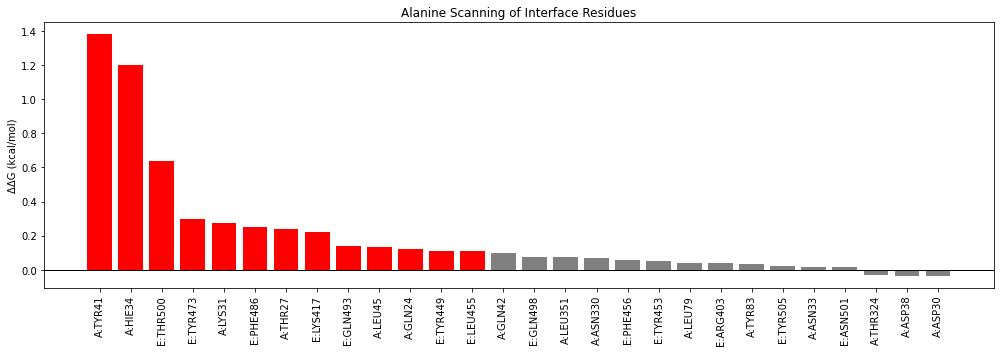

In [60]:
# Now plot the values != 0
import matplotlib.pyplot as plt

def plot_alanine_scan(scan_results, ddG_threshold):
    """
    Bar plot of ΔΔG per residue.
    Residues with |ΔΔG| > ddG_threshold are highlighted in red.
    """
    labels = [f"{r['chain']}:{r['resname']}{r['resid']}" for r in scan_results]
    ddGs   = [r["ddG"] for r in scan_results]

    colors = ["red" if abs(ddG) > ddG_threshold else "grey" for ddG in ddGs]

    plt.figure(figsize=(14, 5))
    x = range(len(scan_results))
    plt.bar(x, ddGs, color=colors)
    plt.axhline(0.0, color="black", linewidth=1)

    plt.xticks(x, labels, rotation=90)
    plt.ylabel("ΔΔG (kcal/mol)")
    plt.title("Alanine Scanning of Interface Residues")

    plt.tight_layout()
    plt.show()

significant = [r for r in scan_results if abs(r["ddG"]) > 0.01]
plot_alanine_scan(significant, ddG_threshold=0.1)

**KNOWN VARIANTS**

In [61]:

files_to_open = {"c_a": "pdbfiles/complex_alpha.pdb", "c_b": "pdbfiles/complex_beta.pdb", "c_d": "pdbfiles/complex_delta.pdb"} # I have avoided the values for the WT because there are already computed

In [66]:
def check_var(var_name, pdb):
    """previous pipeline reeimplemented"""
    # Structure checking
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure(var_name, pdb)
    pdb_io = PDBIO()
    pdb_io.set_structure(structure)
    clean_f = f"clean_{var_name}.pdb"
    pdb_io.save(f'pdbfiles/{clean_f}', write_end=True, preserve_atom_numbering=True)


    # to get the pdb for each chain in each file
    class SelectChain:
        def __init__(self, chain_id):
            self.chain_id = chain_id
        def accept_model(self, model):
            return 1
        def accept_chain(self, chain):
            return chain.id == self.chain_id
        def accept_residue(self, residue):
            return 1
        def accept_atom(self, atom):
            return 1

    # Save chain A
    pdb_io.set_structure(structure)
    pdb_io.save(f"pdbfiles/{var_name}_chainA.pdb", SelectChain("A"))
    pdb_io.set_structure(structure)
    pdb_io.save(f"pdbfiles/{var_name}_chainE.pdb", SelectChain("E"))

    # Configure structure checking
    p = os.path.dirname(biobb_structure_checking.__file__)
    sclean = structure_checking.StructureChecking(p, args={
        'input_structure_path': f'pdbfiles/{clean_f}',
        'output_structure_path': f"pdbfiles/clean_{var_name}.pdbqt",
        'output_format': 'pdbqt'
    })

    # Execute all the corrections
    sclean.chains()
    sclean.altloc('occupancy')
    sclean.altloc()
    sclean.ligands()
    sclean.amide('auto')
    sclean.chiral()
    sclean.backbone()
    sclean.backbone('--fix_atoms All --fix_chain none --add_caps none')
    sclean.fixside()
    sclean.getss('all')
    sclean.checkall()

    # Add hydrogens
    opts = {'add_mode': 'auto', 'add_charges': 'CMIP'}
    sclean.add_hydrogen(opts)
    sclean.save_structure(f"pdbfiles/clean_{var_name}.pdbqt")

    pdbqt = f"pdbfiles/clean_{var_name}.pdbqt"
    params = {}

    # read pdbqt
    with open(pdbqt, 'r') as f:
        for line in f:
            if line.startswith(('ATOM', 'HETATM')) and len(line) >= 77:
                serial_num = int(line[6:11].strip())
                charge = float(line[69:76].strip())
                atom_type = line[77:].strip()
                params[serial_num] = {'charge': charge, 'type': atom_type}

    # get charges
    st = parser.get_structure(var_name, pdbqt)
    for at in st.get_atoms():
        info = params.get(at.serial_number)
        if info:
            at.xtra["atom_type"] = info["type"]
            at.xtra["charge"] = info["charge"]

    # Interface
    chain1_id = "A"
    chain2_id = "E"
    cutoff = 10.0

    interface_A, interface_E = get_interface_residues(st, chain1_id, chain2_id, cutoff)

    chainA = st[0][chain1_id]
    chainE = st[0][chain2_id]

    expanded_A = expand_residues(interface_A, chainA)
    expanded_E = expand_residues(interface_E, chainE)

    # Save interfaces
    with open(f"interresidues/interfaceA_{var_name}.txt", "w") as f:
        f.write("Chain A interface residues:\n")
        for idx, name in expanded_A:
            f.write(f"{name} {idx}\n")

    with open(f"interresidues/interfaceE_{var_name}.txt", "w") as f:
        f.write("\nChain E interface residues:\n")
        for idx, name in expanded_E:
            f.write(f"{name} {idx}\n")


    # Process interface
    def process_chain_adaptada(interface_file, pdb_file, output_file,chain):
        
        atomsofinter_chain = {}

        # Read interface residues
        with open(interface_file) as f:
            lines = f.readlines()[1:]

        reslocs = {line.strip().split()[1] for line in lines}

        # Read PDBQT
        with open(pdb_file) as f:
            pdb_lines = f.readlines()[:-3]

        # Prepare output file
        with open(output_file, 'w') as out_f:
            for line in pdb_lines:
                tokens = line.strip().split()
                if not tokens or tokens[0] == 'TER':
                    continue

                # Verify that it is an atom line and is in interface residues
                if tokens[0] not in ['ATOM', 'HETATM'] or len(tokens) < 12:
                    continue

                if tokens[5] not in reslocs:
                    continue

                # Write atom to output
                out_f.write(f"{line}")

                # Assign atom parameters
                atom_type_key = tokens[-1]
                if atom_type_key == 'O':
                    interpar = attypepar['OH']
                elif atom_type_key == 'S':
                    interpar = attypepar['SA']
                elif atom_type_key == 'HN':
                    interpar = attypepar['N']
                else:
                    interpar = attypepar.get(atom_type_key, attypepar.get('C', {'sig':'0.0', 'eps':'0.0', 'fsrf':'0.0', 'mass':'0.0'}))

                atomsofinter_chain[tokens[1]] = {
                    'aa': tokens[3], 'type': tokens[-1], 'charge': tokens[-2],
                    'coord': tokens[6:9], 'resloc': tokens[5], 'restype': tokens[4],
                    'sig': interpar['sig'], 'eps': interpar['eps'],
                    'fsrf': interpar['fsrf'], 'mass': interpar['mass']
                }

        return atomsofinter_chain

    # Process both chains
    atomsofinter = {
        'A': process_chain_adaptada(f"interresidues/interfaceA_{var_name}.txt",
                                   pdbqt,
                                   f"interresidues/chainAinterface_{var_name}.pdbqt",
                                   'A'),
        'E': process_chain_adaptada(f"interresidues/interfaceE_{var_name}.txt",
                                   pdbqt,
                                   f"interresidues/chainEinterface_{var_name}.pdbqt",
                                   'E')
    }


    # Compute energies
    def paiwiseenergy(atomsofinter_dict):
        interactions = {}
        E_elec = 0.0
        E_vdw = 0.0

        for a_key in atomsofinter_dict['A']:
            a = atomsofinter_dict['A'][a_key]
            coord_a = np.array([float(x) for x in a['coord']])
            q_a = float(a['charge'])
            sig1 = float(a['sig'])
            eps1 = float(a['eps'])

            for e_key in atomsofinter_dict['E']:
                e = atomsofinter_dict['E'][e_key]
                coord_e = np.array([float(x) for x in e['coord']])
                q_e = float(e['charge'])
                sig2 = float(e['sig'])
                eps2 = float(e['eps'])

                r = np.linalg.norm(coord_a - coord_e)
                if r < 8.0:
                    elec = electrointeraction(r, q_a, q_e)
                    vdw = vdw_int(r, sig1, sig2, eps1, eps2)
                    E_elec += elec
                    E_vdw += vdw

                    interactions[(a['aa'], a['resloc'], e['aa'], e['resloc'])] = {
                        'elec': elec,
                        'vdw': vdw,
                        'distance': r
                    }

        return E_elec, E_vdw, interactions

    E_elec, E_vdw, interactions = paiwiseenergy(atomsofinter)
    print(f"   Electrostatics: {E_elec:.3f} kcal/mol")
    print(f"   Van der Waals: {E_vdw:.3f} kcal/mol")

    # Solvation Energy
    def parse_asa_file_adaptada(asa_file_path):
        """Parsear archivo ASA con manejo de errores"""
        atom_asa = {}

        with open(asa_file_path, 'r') as f:
            for line in f:
                if line.startswith('ATOM'):
                    atom_num = int(line[6:11].strip())
                    atom_name = line[12:16].strip()
                    asa = float(line[62:68].strip()) if len(line) >= 68 else 0.0

                    atom_asa[str(atom_num)] = {'asa': asa, 'type': atom_name}

        return atom_asa

    # the asa files where manually generated
    asa_complex = parse_asa_file_adaptada(f"naccessoutputs/clean_{var_name}.asa")
    asa_chain_a = parse_asa_file_adaptada(f"naccessoutputs/{var_name}_chainA.asa")
    asa_chain_e = parse_asa_file_adaptada(f"naccessoutputs/{var_name}_chainE.asa")

    def computesolvenerg_adaptada(asa_dict, atomsofinter_dict):
        solve = 0.0

        for a_key in asa_dict:
            # Check if the atom is at the interface
            in_chain_a = a_key in atomsofinter_dict['A']
            in_chain_e = a_key in atomsofinter_dict['E']

            if not (in_chain_a or in_chain_e):
                continue

            atom_info = asa_dict[a_key]
            atom_type = atom_info['type']

            # Determine fsrf according to atom type
            if atom_type == 'O':
                fsrf = float(attypepar['OA']['fsrf'])
            elif atom_type == 'CA' or atom_type == 'CB':
                fsrf = float(attypepar['C']['fsrf'])
            elif atom_type[:2] == 'OG':
                fsrf = float(attypepar['OH']['fsrf'])
            elif atom_type[:2] in ('CG1', 'CG', 'CD', 'CD2', 'CE', 'CE2', 'CZ', 'CG2',
                                  'CD1', 'CE1', 'CE3', 'CH2'):
                fsrf = float(attypepar['A']['fsrf'])
            elif atom_type[:2] == 'HG':
                fsrf = float(attypepar['H']['fsrf'])
            elif atom_type in ('OD1', 'OD2', 'OE1', 'OE2'):
                fsrf = float(attypepar['OC']['fsrf'])
            elif atom_type[0] == 'N':
                fsrf = float(attypepar['N']['fsrf'])
            elif atom_type[:2] in ('HZ1', 'HZ2', 'HZ3', 'HE', 'HD'):
                fsrf = float(attypepar['N']['fsrf'])
            else:
                fsrf = float(attypepar.get('C', {'fsrf': '0.0'})['fsrf'])

            asaval = atom_info['asa']
            solve += fsrf * asaval

        return solve

    # energies
    solv_comp = computesolvenerg_adaptada(asa_complex, atomsofinter) if asa_complex else 0.0
    solv_a = computesolvenerg_adaptada(asa_chain_a, atomsofinter) if asa_chain_a else 0.0
    solv_e = computesolvenerg_adaptada(asa_chain_e, atomsofinter) if asa_chain_e else 0.0

    print(f"   Solvation AE: {solv_comp:.3f}")
    print(f"   Solvation A: {solv_a:.3f}")
    print(f"   Solvation E: {solv_e:.3f}")

    # Final
    delta_solv = solv_comp - solv_a - solv_e
    total_energy = E_elec + E_vdw + delta_solv

    print(f"   ΔSolvation: {delta_solv:.3f}")
    print(f"   TOTAL ENERGY: {total_energy:.3f} kcal/mol")

    # Visualizations: plots, tables, ...
    if interactions:
        plot_electrostatic_energy_distribution(interactions, 10)
        plot_vdw_energy_distribution(interactions, 10)
        df_classified = classify_and_plot_interactions(interactions)
        df_table = generate_interaction_table(interactions, 10)
        with open(f"pdbfiles/interactions_{var_name}.pkl", 'wb') as f:
            pickle.dump(interactions, f)

    ans = {
        'variante': var_name,
        'E_elec': E_elec,
        'E_vdw': E_vdw,
        'solv_comp': solv_comp,
        'solv_a': solv_a,
        'solv_e': solv_e,
        'delta_solv': delta_solv,
        'total': total_energy,
        'num_interacciones': len(interactions) if interactions else 0,
        'num_res_A': len(expanded_A),
        'num_res_E': len(expanded_E)
    }

    return ans

Final output of variant analysis

Structure pdbfiles/clean_c_a.pdb loaded
 PDB id:  
 Title: 
 Experimental method: unknown
 Resolution (A): N.A.

 Num. models: 1
 Num. chains: 2 (A: Protein, E: Protein)
 Num. residues:  791
 Num. residues with ins. codes:  0
 Num. residues with H atoms: 0
 Num. HETATM residues:  0
 Num. ligands or modified residues:  0
 Num. water mol.:  0
 Num. atoms:  6406
Running chains.
Detected 2 Chain(s)
 A: Protein
 E: Protein
Running altloc. Options: occupancy
Detected 2 residues with alternative location labels
HIS A228
  CA   A (0.50) B (0.50)
  CB   A (0.50) B (0.50)
  CG   A (0.50) B (0.50)
  CD2  A (0.50) B (0.50)
  ND1  A (0.50) B (0.50)
  CE1  A (0.50) B (0.50)
  NE2  A (0.50) B (0.50)
GLN E493
  CA   A (0.50) B (0.50)
  CB   A (0.50) B (0.50)
  CG   A (0.50) B (0.50)
  CD   A (0.50) B (0.50)
  NE2  A (0.50) B (0.50)
  OE1  A (0.50) B (0.50)
Selecting location occupancy
Running altloc.
Detected no residues with alternative location labels
Running ligands.
No ligands found
Running amide.

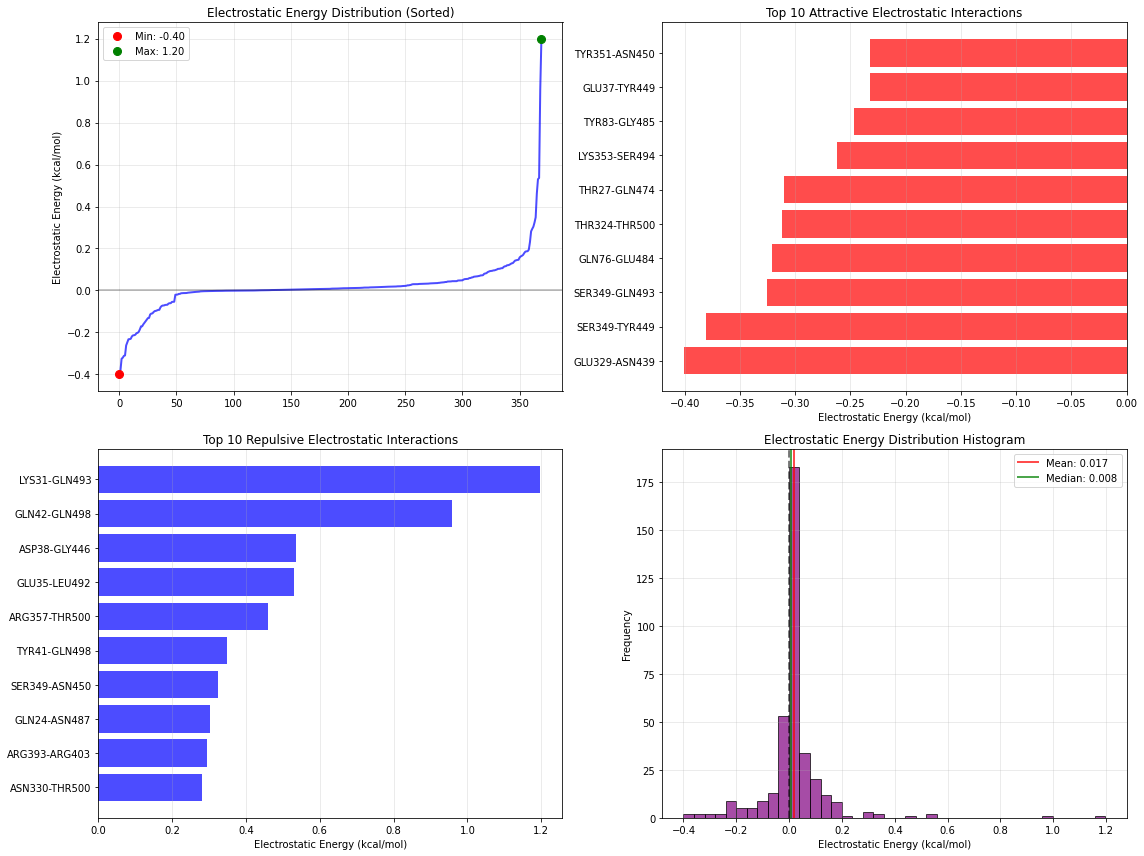

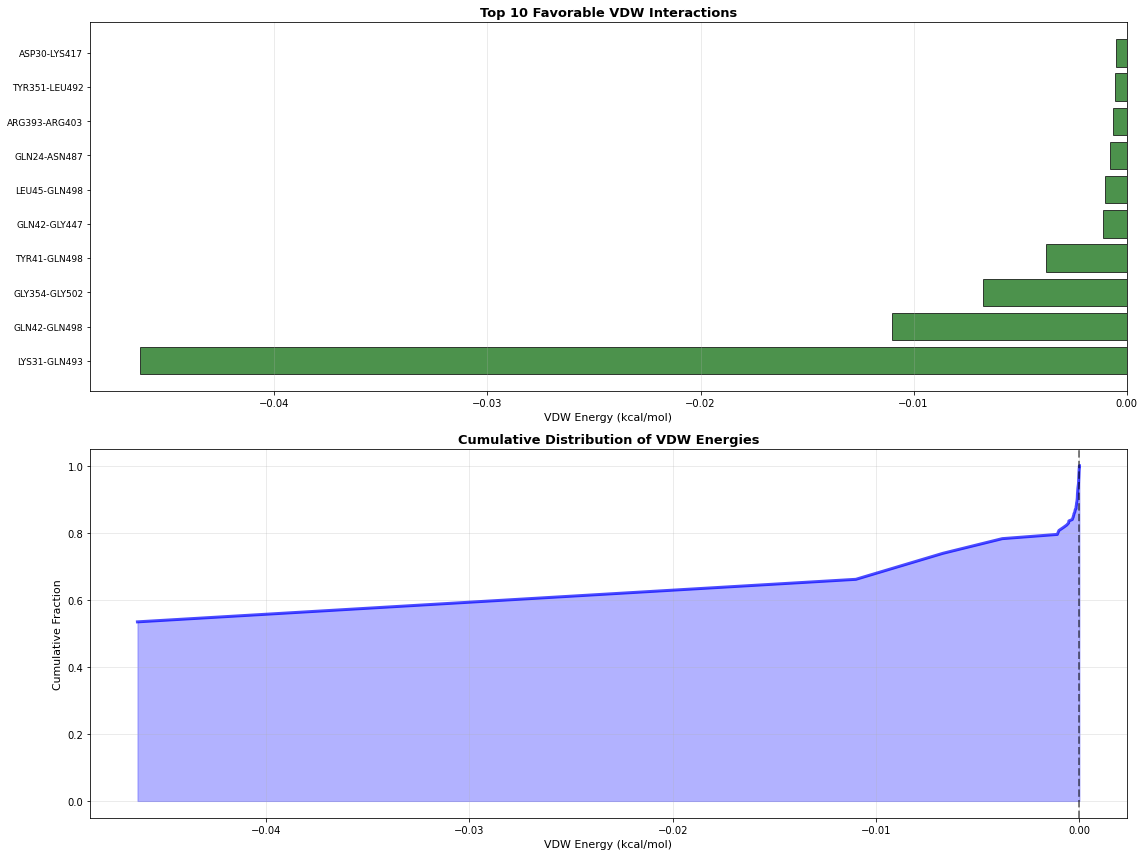

/tmp/ipykernel_1364/3267477878.py:113: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 0].boxplot(box_data, labels=df['Type'].unique())


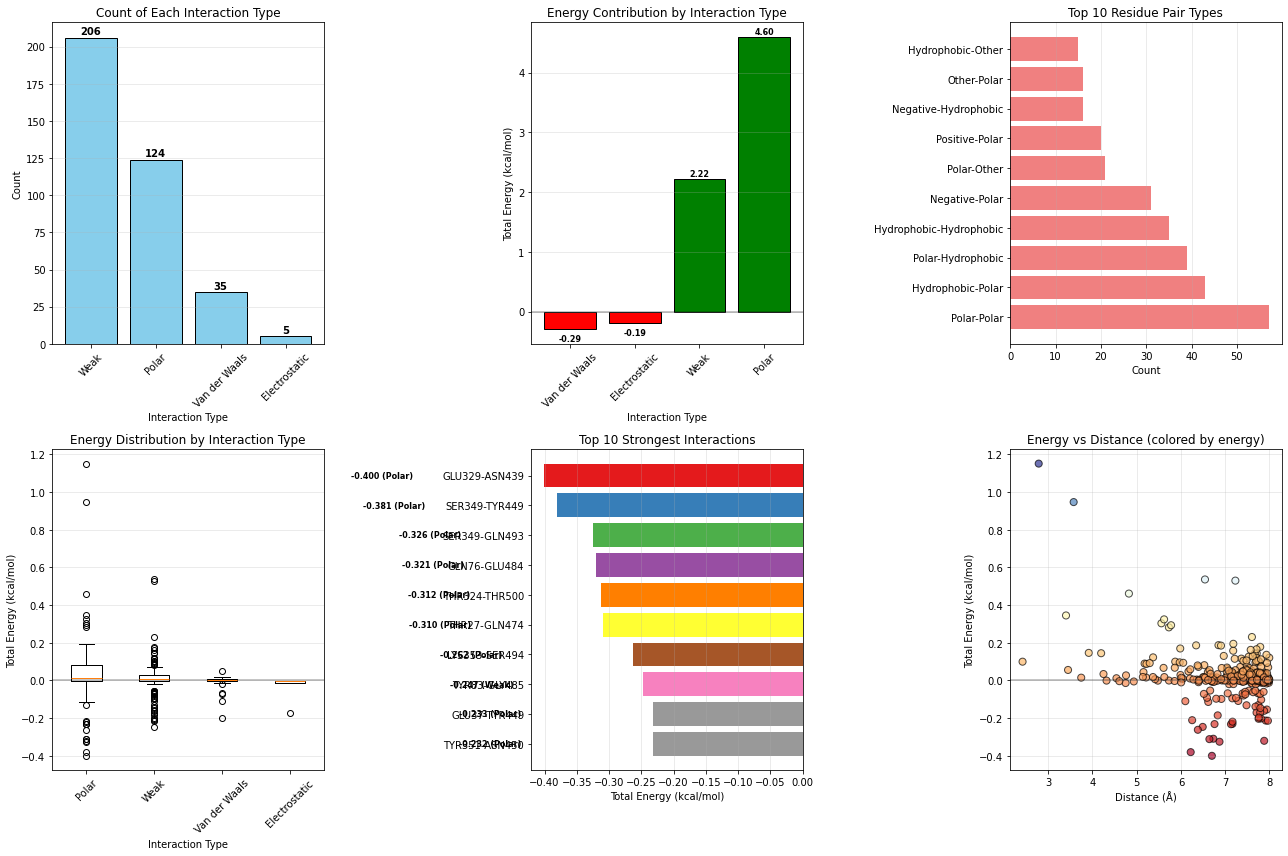


Top 10 interactions sorted by interaction strength:

 Rank ACE2_Residue RBD_Residue Electrostatic_Energy VDW_Energy Total_Energy Favorable Interaction_Type Strength
    1        LYS31      GLN493                1.198     -0.046        1.151        No       Mixed Weak Moderate
    2        GLN42      GLN498                0.958     -0.011        0.947        No       Mixed Weak     Weak
    3        ASP38      GLY446                0.536     -0.000        0.536        No       Mixed Weak     Weak
    4        GLU35      LEU492                0.530     -0.000        0.530        No       Mixed Weak     Weak
    5       ARG357      THR500                0.461     -0.000        0.461        No       Mixed Weak     Weak
    6       GLU329      ASN439               -0.400     -0.000       -0.400       Yes       Mixed Weak     Weak
    7       SER349      TYR449               -0.381     -0.000       -0.381       Yes       Mixed Weak     Weak
    8        TYR41      GLN498                0.34

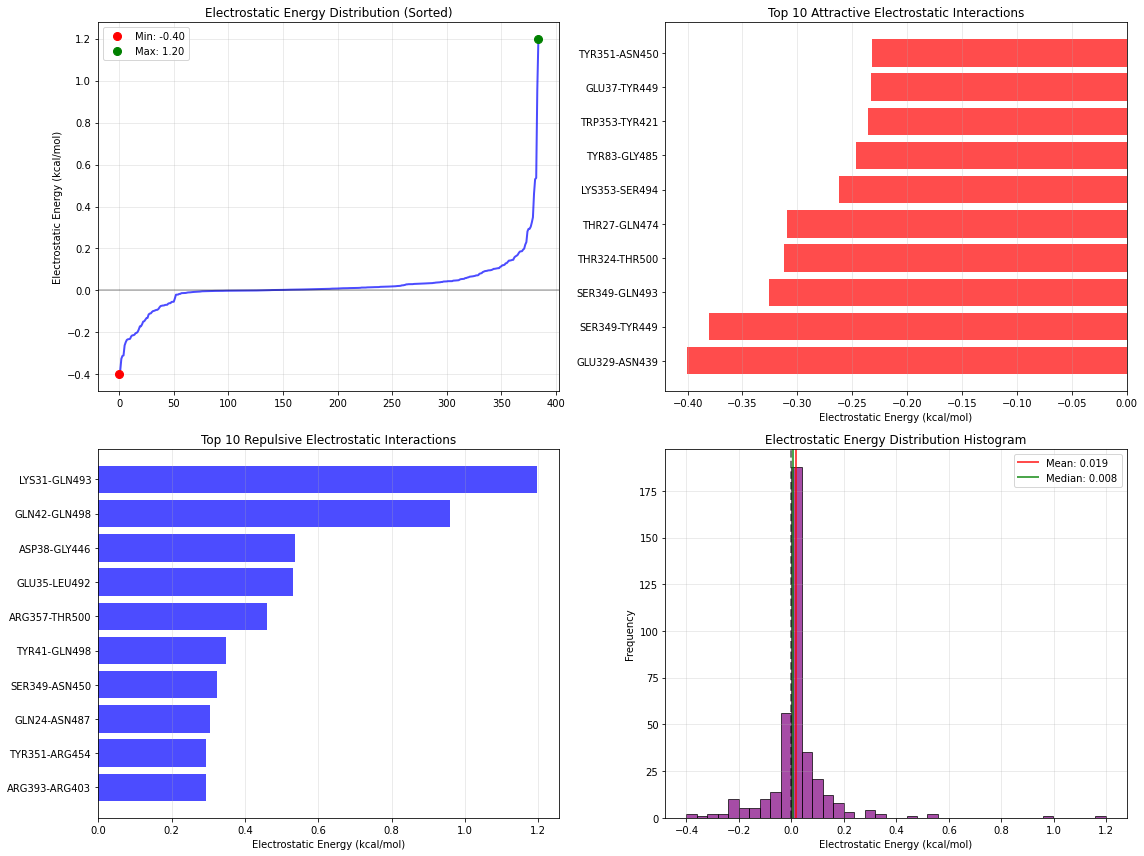

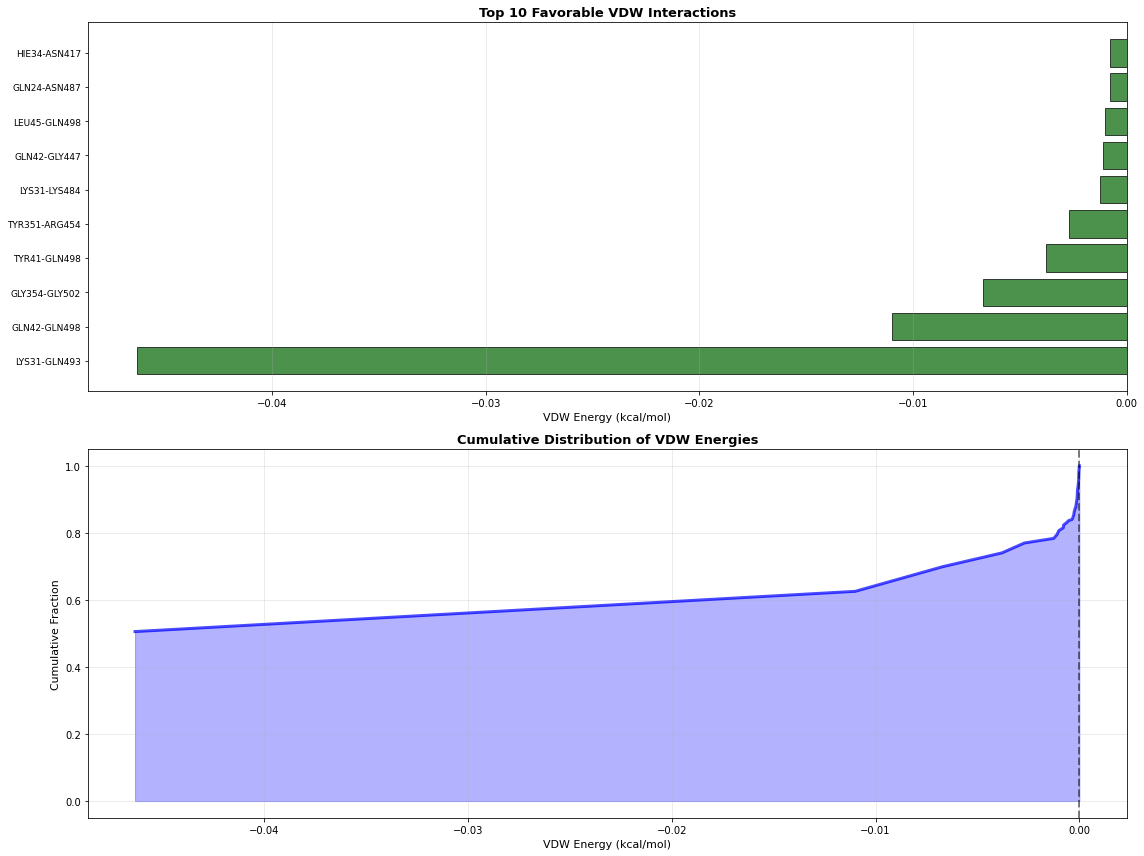

/tmp/ipykernel_1364/3267477878.py:113: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 0].boxplot(box_data, labels=df['Type'].unique())


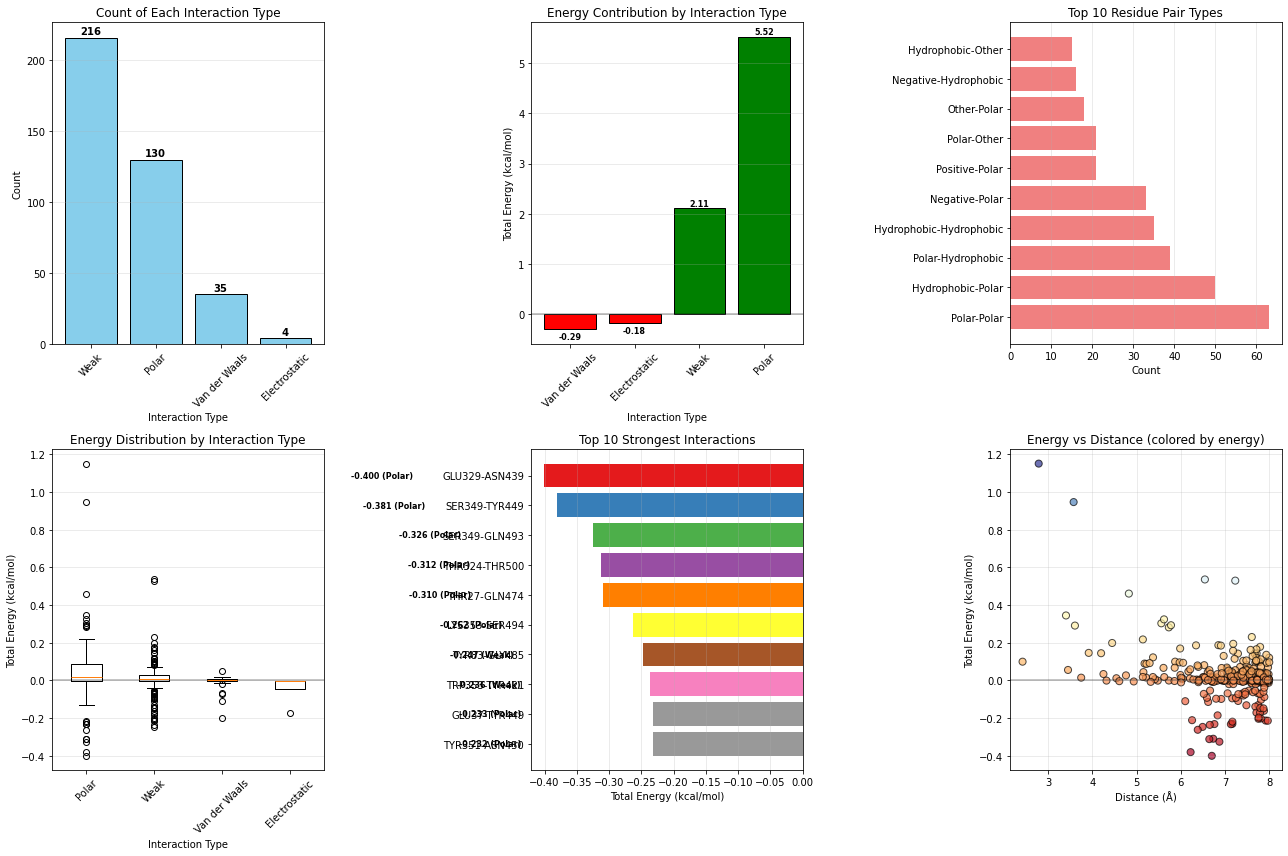


Top 10 interactions sorted by interaction strength:

 Rank ACE2_Residue RBD_Residue Electrostatic_Energy VDW_Energy Total_Energy Favorable Interaction_Type Strength
    1        LYS31      GLN493                1.198     -0.046        1.151        No       Mixed Weak Moderate
    2        GLN42      GLN498                0.958     -0.011        0.947        No       Mixed Weak     Weak
    3        ASP38      GLY446                0.536     -0.000        0.536        No       Mixed Weak     Weak
    4        GLU35      LEU492                0.530     -0.000        0.530        No       Mixed Weak     Weak
    5       ARG357      THR500                0.461     -0.000        0.461        No       Mixed Weak     Weak
    6       GLU329      ASN439               -0.400     -0.000       -0.400       Yes       Mixed Weak     Weak
    7       SER349      TYR449               -0.381     -0.000       -0.381       Yes       Mixed Weak     Weak
    8        TYR41      GLN498                0.34

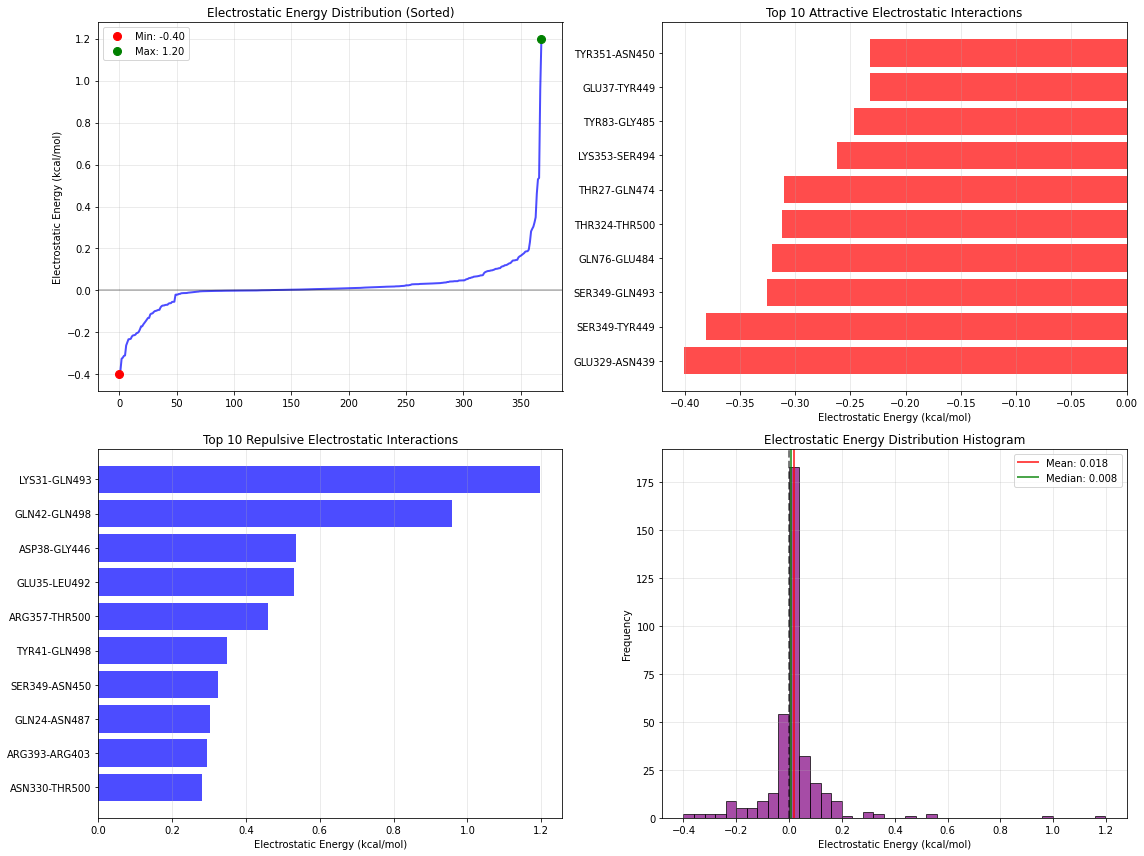

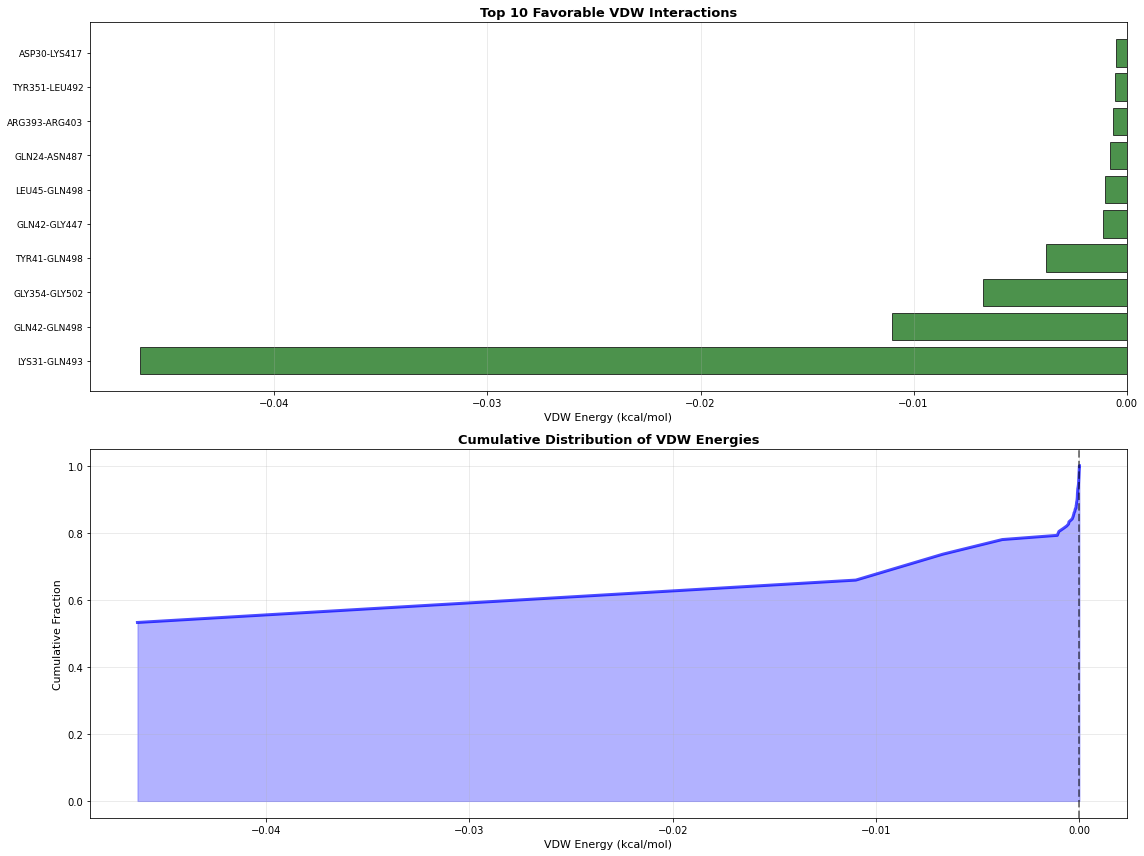

/tmp/ipykernel_1364/3267477878.py:113: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 0].boxplot(box_data, labels=df['Type'].unique())


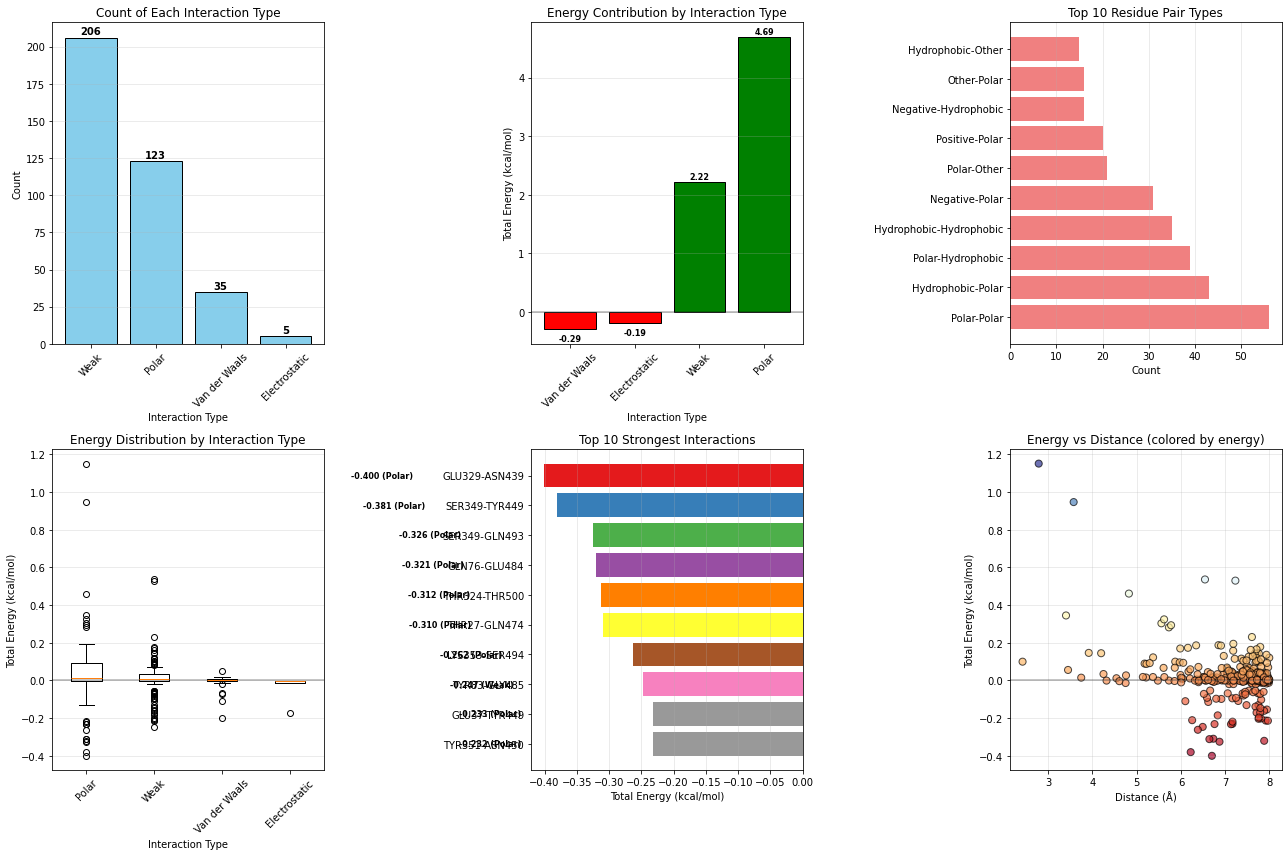


Top 10 interactions sorted by interaction strength:

 Rank ACE2_Residue RBD_Residue Electrostatic_Energy VDW_Energy Total_Energy Favorable Interaction_Type Strength
    1        LYS31      GLN493                1.198     -0.046        1.151        No       Mixed Weak Moderate
    2        GLN42      GLN498                0.958     -0.011        0.947        No       Mixed Weak     Weak
    3        ASP38      GLY446                0.536     -0.000        0.536        No       Mixed Weak     Weak
    4        GLU35      LEU492                0.530     -0.000        0.530        No       Mixed Weak     Weak
    5       ARG357      THR500                0.461     -0.000        0.461        No       Mixed Weak     Weak
    6       GLU329      ASN439               -0.400     -0.000       -0.400       Yes       Mixed Weak     Weak
    7       SER349      TYR449               -0.381     -0.000       -0.381       Yes       Mixed Weak     Weak
    8        TYR41      GLN498                0.34

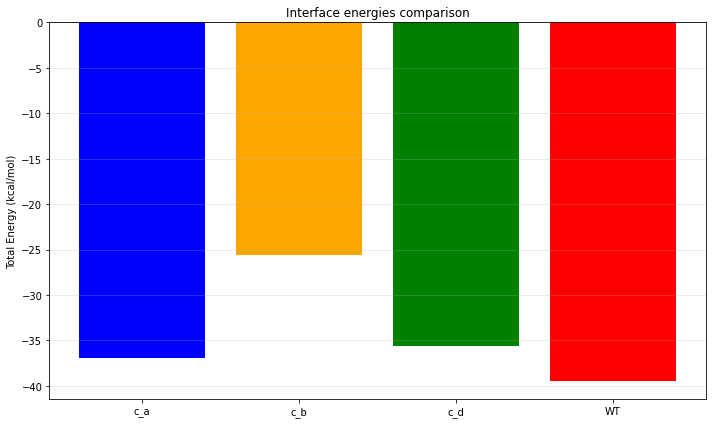

In [67]:
ans = []

for cl, fl in files_to_open.items():
    res = check_var(cl, fl)
    ans.append(res)

# Add the WT information for the final plot
WT = {
    'variante': 'WT',
    'E_elec': -16.287,
    'E_vdw': -8.667,
    'solv_comp': 27.928,
    'solv_a': 8.424,
    'solv_e': 33.193,
    'delta_solv':  27.928-8.424-33.193,
    'total': -39.4589,
    'num_interacciones': 369,
    'num_res_A': 106,
    'num_res_E': 48
}
ans.append(WT)  #Adds WT to the list
# comp table
df = pd.DataFrame(ans)

print("Comparison of Variants")
print("="*60)
print(df.to_string(index=False))

var = [r['variante'] for r in ans]
e_total = [r['total'] for r in ans]

plt.figure(figsize=(10, 6))
plt.bar(var, e_total, color=['blue', 'orange', 'green', 'red'])
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.ylabel('Total Energy (kcal/mol)')
plt.title('Interface energies comparison')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()